# Semantic Segmentation of Aerial Satellite Imagery 

## 1. Importing the Necessary libraries

In [104]:
from tensorflow.keras import layers  
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU

import numpy as np
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
import seaborn as sns
import cv2
from tqdm.notebook import tqdm
from random import shuffle

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras import backend as K

from skimage.filters import sobel
from skimage import img_as_ubyte

import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable

import math
from glob import glob
import sys
import shutil
import random
import PIL
from scipy import ndimage

%matplotlib inline

## 2. Loading and preprocessing the data

In [23]:
class SegmentationDataset1(Sequence):
    def __init__(self, root_dir, class_file, image_size=(128, 128), batch_size=8, num_classes=6):
        """
        Args:
            root_dir (str): Path to the root dataset directory.
            class_file (str): Path to the class metadata JSON file.
            image_size (tuple): Target size of images (H, W).
            batch_size (int): Number of samples per batch.
            num_classes (int): Total number of segmentation classes.
        """
        self.root_dir = root_dir
        self.class_file = class_file
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.image_paths = []
        self.mask_paths = []

        # Load and parse the class metadata
        self.class_info = self._load_class_metadata()
        
        # Scan dataset for images and masks
        self._scan_dataset()

    def _load_class_metadata(self):
        with open(self.class_file, 'r') as f:
            class_metadata = json.load(f)
        
        # Extract class information (you may add more processing depending on structure)
        class_labels = [cls["title"] for cls in class_metadata["classes"]]  # Class IDs
        return class_metadata["classes"]

    def _scan_dataset(self):
        for tile in os.listdir(self.root_dir):  # Iterate over tile_1, tile_2, etc.
            tile_path = os.path.join(self.root_dir, tile)
            images_dir = os.path.join(tile_path, 'images')
            masks_dir = os.path.join(tile_path, 'masks')

            if os.path.isdir(images_dir) and os.path.isdir(masks_dir):
                images = sorted([os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.endswith(('.png', '.jpg'))])
                masks = sorted([os.path.join(masks_dir, msk) for msk in os.listdir(masks_dir) if msk.endswith(('.png', '.jpg'))])

                assert len(images) == len(masks), f"Image and mask counts mismatch in {tile}"
                self.image_paths.extend(images)
                self.mask_paths.extend(masks)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
    
        images = []
        masks = []
    
        for img_path, mask_path in zip(batch_images, batch_masks):
            img = load_img(img_path, target_size=self.image_size)
            img = img_to_array(img) / 255.0  
    
            mask = load_img(mask_path, target_size=self.image_size, color_mode='grayscale')  
            mask = img_to_array(mask)  
    
            mask = np.clip(mask, 0, self.num_classes - 1)
    
            mask = to_categorical(mask, num_classes=self.num_classes)
    
            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

## 3.1. Custom functions for the evaluation metrics and it's corresponding visualization

In [9]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy')
        plt.title('Training Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def print_final_accuracy(history):
    if 'accuracy' in history.history:
        final_training_accuracy = history.history['accuracy'][-1]
        print(f"Final Training Accuracy: {final_training_accuracy:.2%}")

    if 'val_accuracy' in history.history:
        final_validation_accuracy = history.history['val_accuracy'][-1]
        print(f"Final Validation Accuracy: {final_validation_accuracy:.2%}")

## 3.2. Defining segmentation-specific metrics

In [41]:
class ClassWiseIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name="class_wise_iou", **kwargs):
        super(ClassWiseIoU, self).__init__(num_classes=num_classes, name=name, **kwargs)

    def result_per_class(self):
        total_cm = self.total_cm.numpy()
        iou_per_class = []
        for i in range(total_cm.shape[0]):
            intersection = total_cm[i, i]
            union = sum(total_cm[i, :]) + sum(total_cm[:, i]) - intersection
            iou = intersection / union if union != 0 else 0
            iou_per_class.append(iou)
        return iou_per_class

## 4.1. Defining the U - Net (Universal - Net or U - shaped network) Architecture

In [3]:
def unet_model(input_size=(128, 128, 3), num_classes=6):
    inputs = layers.Input(shape=input_size)

    # Encoder: Contracting path with Conv2D and MaxPooling
    # First convolution block
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Second convolution block
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Third convolution block
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Fourth convolution block
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(c5)

    # Decoder: Expanding path with Conv2DTranspose (Upsampling) and Concatenation
    # First upsampling block
    u6 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

    # Second upsampling block
    u7 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

    # Third upsampling block
    u8 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

    # Fourth upsampling block
    u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

    # Final output layer (segmentation mask) - change to 'num_classes' for multi-class output
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(c9)

    model = Model(inputs, outputs)

    return model

## 4.2. Training the U - Net Model

In [80]:
# Dataset setup
dataset_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"  
class_file = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/classes.json"  
batch_size = 8
image_size = (128, 128)
num_classes = 6  

train_dataset = SegmentationDataset1(dataset_path, class_file=class_file, image_size=image_size, batch_size=batch_size, num_classes=num_classes)

# Model setup (U-Net)
model = unet_model(input_size=(image_size[0], image_size[1], 3))  # Ensure to define the U-Net model

iou_unet = ClassWiseIoU(num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=[MeanIoU(num_classes=num_classes),'accuracy', iou_unet])

hunet = model.fit(train_dataset, epochs=20)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.9743 - class_wise_iou: 0.6116 - loss: 3290.8977 - mean_io_u_13: 0.6116
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9985 - class_wise_iou: 0.4417 - loss: 0.3760 - mean_io_u_13: 0.4417
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9602 - class_wise_iou: 0.9486 - loss: 149.1500 - mean_io_u_13: 0.9486
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.7950 - class_wise_iou: 0.4167 - loss: 0.8930 - mean_io_u_13: 0.4167
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9126 - class_wise_iou: 0.4167 - loss: 0.7343 - mean_io_u_13: 0.4167
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9960 - class_wise_iou: 0.6254 - loss: 0.1009 - mean_io_u_13: 0.6254
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9958 - class_wise_iou: 0.6172 - loss: 0.0867 - mean_io_u_13: 0.6172
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.9976 - class_wise

## 4.3. Evaluation Metrics

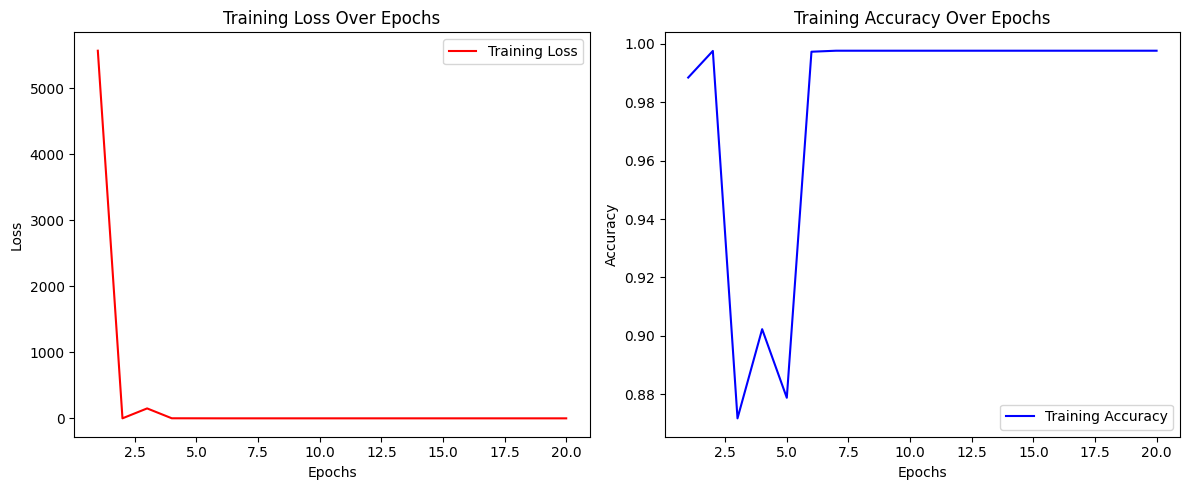

Final Training Accuracy: 99.76%


In [81]:
plot_training_history(hunet)
print_final_accuracy(hunet)

## 5.1. Defining the DeepLab V3+ model with encoder and decoder (multi-class version)

In [58]:
def deeplabv3_plus(input_shape=(None, None, 3), num_classes=6):
    inputs = layers.Input(shape=input_shape)

    # Encoder: Xception backbone (feature extractor)
    base_model = Xception(input_shape=input_shape, include_top=False)

    # Extracting features using the encoder (Xception model)
    x = base_model(inputs)

    # Decoder: Upsampling and convolution layers to generate segmentation mask
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)

    # Instead of 4x upsampling, performing multiple upsampling steps to get to the original size
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)  # Upsampling from (4x4) to (16x16)
    x = layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)    # Output num_classes channels

    # Final upsampling to the original input size (128x128)
    x = layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(x)  # Upsampling from (16x16) to (128x128)

    model = Model(inputs, x)

    return model

# Custom dataset class to load images and masks
class SegmentationDataset2(tf.keras.utils.Sequence):
    def __init__(self, root_dir, image_size=(128, 128), batch_size=8, num_classes=6):
        self.root_dir = root_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.image_paths = []
        self.mask_paths = []
        self._scan_dataset()
        
    def _scan_dataset(self):
        for tile in os.listdir(self.root_dir):  # Iterate over tile_1, tile_2, etc.
            tile_path = os.path.join(self.root_dir, tile)
            images_dir = os.path.join(tile_path, 'images')
            masks_dir = os.path.join(tile_path, 'masks')

            if os.path.isdir(images_dir) and os.path.isdir(masks_dir):
                images = sorted([os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.endswith(('.png', '.jpg'))])
                masks = sorted([os.path.join(masks_dir, msk) for msk in os.listdir(masks_dir) if msk.endswith(('.png', '.jpg'))])

                assert len(images) == len(masks), f"Image and mask counts mismatch in {tile}"
                self.image_paths.extend(images)
                self.mask_paths.extend(masks)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_images, batch_masks):
            img = Image.open(img_path).resize(self.image_size).convert('RGB')
            mask = Image.open(mask_path).resize(self.image_size).convert('L')

            images.append(np.array(img) / 255.0)  # Normalize images to [0, 1]
            mask_array = np.array(mask) / 255.0  # Normalize mask to [0, 1]
            masks.append(self.one_hot_encode(mask_array))  # Convert mask to one-hot encoding

        return np.array(images), np.array(masks)  # Return images and one-hot encoded masks

    def one_hot_encode(self, mask):
        """
        Converts a mask to one-hot encoding.
        Args:
            mask (ndarray): Grayscale mask array where each pixel corresponds to a class index.
        Returns:
            ndarray: One-hot encoded mask.
        """
        one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes))
        for i in range(self.num_classes):
            one_hot[:, :, i] = (mask == i).astype(int)
        return one_hot

# Dataset setup
dataset_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"  
batch_size = 8
image_size = (128, 128)
num_classes = 6

train_dataset = SegmentationDataset2(dataset_path, image_size=image_size, batch_size=batch_size, num_classes=num_classes)

# Model setup
deeplab_model = deeplabv3_plus(input_shape=(image_size[0], image_size[1], 3), num_classes=num_classes)

iou_dlv = ClassWiseIoU(num_classes=num_classes)

# Compiling the model with CategoricalCrossentropy (for multi-class segmentation) and MeanIoU metric
deeplab_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss=CategoricalCrossentropy(),
                      metrics=[MeanIoU(num_classes=num_classes),'accuracy', iou_dlv])

# Model summary
deeplab_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 4, 4, 256)      │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 16, 16, 6)      │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 128, 128, 6)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,949,550 (98.99 MB)

 Trainable params: 25,895,022 (98.78 MB)

 Non-trainable params: 54,528 (213.00 KB)

## 5.2. Training the model

In [59]:
hdl = deeplab_model.fit(train_dataset, epochs=20)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.4227 - class_wise_iou: 0.5500 - loss: 2.3576e-04 - mean_io_u_8: 0.5500
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 1.0000 - class_wise_iou: 0.6038 - loss: 1.6988e-10 - mean_io_u_8: 0.6038
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 1.0000 - class_wise_iou: 0.4685 - loss: 4.8153e-11 - mean_io_u_8: 0.4685
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 1.0000 - class_wise_iou: 0.4673 - loss: 2.1484e-10 - mean_io_u_8: 0.4673
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 1.0000 - class_wise_iou: 0.4581 - loss: 2.5826e-11 - mean_io_u_8: 0.4581
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 1.0000 - class_wise_iou: 0.4604 - loss: 8.1096e-11 - mean_io_u_8: 0.4604
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 1.0000 - class_wise_iou: 0.4585 - loss: 8.0950e-11 - mean_io_u_8: 0.4585
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 1.0000 

## 5.3. Evaluation metrics

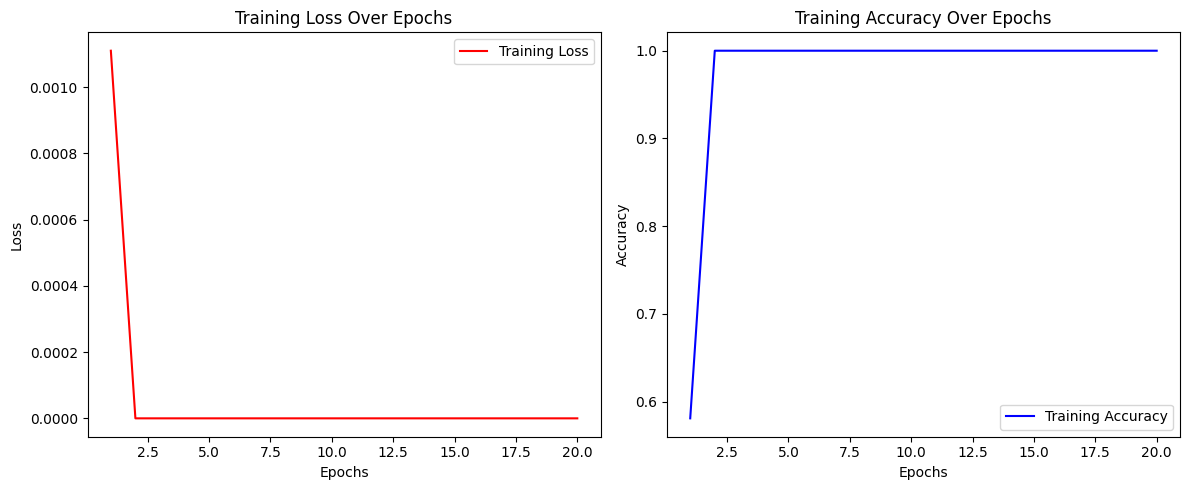

Final Training Accuracy: 100.00%


In [63]:
plot_training_history(hdl)
print_final_accuracy(hdl)

## 6.1. Efficient Neural Network (E - Net) Architecure

In [68]:
# ENet Block: Convolution, BatchNorm, and Activation
def enet_block(x, filters, kernel_size=(3, 3), stride=1, dilation_rate=1, padding='same'):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, dilation_rate=dilation_rate, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# ENet Bottleneck Block
def enet_bottleneck(x, filters, stride=1):
    residual = x
    x = enet_block(x, filters, stride=stride)  # First block
    x = enet_block(x, filters, stride=1)  # Second block
    x = enet_block(x, filters, stride=1)  # Third block

    if residual.shape[-1] != filters:  # If input channels don't match output, apply 1x1 convolution
        residual = layers.Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(residual)

    return layers.Add()([x, residual])

# ENet Encoder: Initial convolutional layers and bottleneck blocks
def enet_encoder(x):
    x = enet_block(x, 16, kernel_size=(3, 3), stride=2)  # Initial convolution
    x = enet_bottleneck(x, 32, stride=2)  # Bottleneck block 1
    x = enet_bottleneck(x, 64, stride=2)  # Bottleneck block 2
    return x
    
# ENet Decoder: Upsampling and final classification layer
def enet_decoder(x, num_classes, target_size=(128, 128)):
    # Upsampling with Conv2DTranspose or UpSampling2D to match target size
    x = layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=2, padding='same')(x)  # Upsample 1
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(32, kernel_size=(4, 4), strides=2, padding='same')(x)  # Upsample 2
    x = layers.ReLU()(x)

    # Ensuring the output is the same size as the input (target size)
    x = layers.Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=2, padding='same')(x)  # Final upsample
    x = layers.ReLU()(x)

    # Resizing to target size (128x128) using upsampling
    x = layers.UpSampling2D(size=(1, 1))(x)  

    return x

# ENet Model Definition
def enet_model(input_size=(128, 128, 3), num_classes=6):
    inputs = layers.Input(shape=input_size)
    
    # Encoder: extracting features
    x = enet_encoder(inputs)

    # Decoder: upsampling and generating segmentation output
    x = enet_decoder(x, num_classes)

    model = Model(inputs, x)
    return model

# Model setup
image_size = (128, 128, 3)  # Input image size (height, width, channels)
num_classes = 6  # Number of classes for segmentation

model1= enet_model(input_size=image_size, num_classes=num_classes)

iou_enet = ClassWiseIoU(num_classes=num_classes)
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=[MeanIoU(num_classes=num_classes),'accuracy', iou_enet])

model1.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_140 (Conv2D) │ (None, 64, 64,    │        448 │ input_layer_12[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_140[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_40 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 32, 32,    │      4,640 │ re_lu_40[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_141[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_41 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 32, 32,    │      9,248 │ re_lu_41[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_142[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_42 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (None, 32, 32,    │      9,248 │ re_lu_42[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_143[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_43 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 32, 32,    │        544 │ re_lu_40[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_42 (Add)        │ (None, 32, 32,    │          0 │ re_lu_43[0][0],   │
│                     │ 32)               │            │ conv2d_144[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_145 (Conv2D) │ (None, 16, 16,    │     18,496 │ add_42[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_145[0][0]

 Total params: 221,286 (864.40 KB)

 Trainable params: 220,678 (862.02 KB)

 Non-trainable params: 608 (2.38 KB)

## 6.2. Training the model

In [69]:
dataset_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"  
class_file = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/classes.json"  
batch_size = 8
image_size = (128, 128)
num_classes = 6  

train_dataset = SegmentationDataset1(dataset_path, class_file=class_file, image_size=image_size, batch_size=batch_size, num_classes=num_classes)

henet = model1.fit(train_dataset, epochs=20)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5303 - class_wise_iou: 0.4167 - loss: nan - mean_io_u_9: 0.4167
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9977 - class_wise_iou: 0.3039 - loss: nan - mean_io_u_9: 0.3039
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9986 - class_wise_iou: 0.2856 - loss: 0.0237 - mean_io_u_9: 0.2856
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9989 - class_wise_iou: 0.3771 - loss: 0.0173 - mean_io_u_9: 0.3771   
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9989 - class_wise_iou: 0.3459 - loss: 0.0172 - mean_io_u_9: 0.3459   
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9937 - class_wise_iou: 0.3448 - loss: 0.1020 - mean_io_u_9: 0.3448
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9981 - class_wise_iou: 0.3293 - loss: 0.0300 - mean_io_u_9: 0.3293   
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9995 - class_wise_iou: 0.3444 - lo

## 6.3. Evaluation metrics

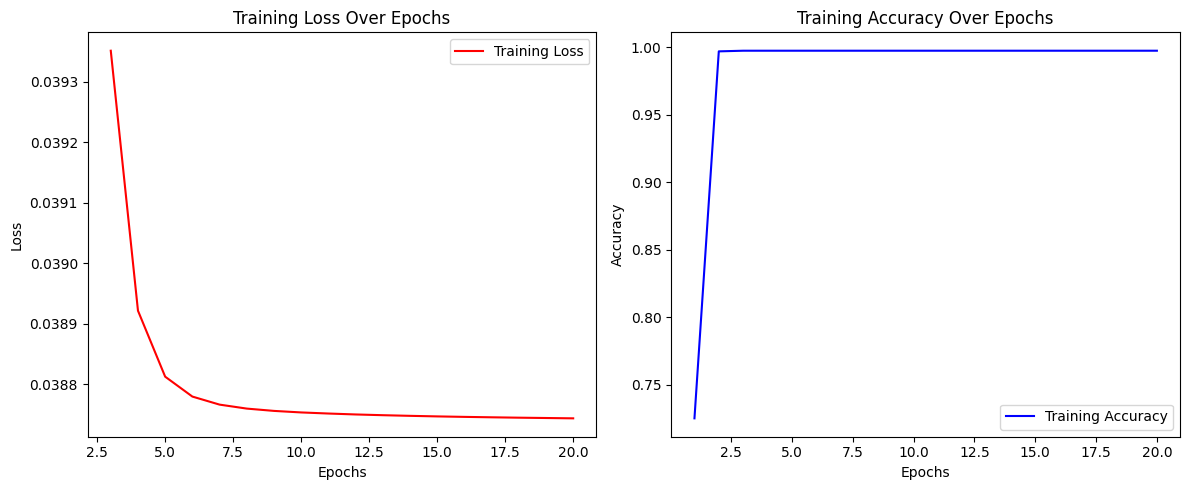

Final Training Accuracy: 99.76%


In [70]:
plot_training_history(henet)
print_final_accuracy(henet)

## 7.1. Attention U-Net (Att U-Net) Architecure

In [72]:
# Attention Gate
def attention_gate(x, g, filters):
    """
    Attention gate to apply to the skip connection.
    x: input feature map
    g: gating signal (usually from the encoder layer)
    filters: number of filters for the convolution layer
    """
    g1 = layers.Conv2D(filters, (1, 1), padding='same')(g)
    g1 = layers.BatchNormalization()(g1)
    g1 = layers.ReLU()(g1)
    
    x1 = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)
    
    merge = layers.Add()([x1, g1])
    merge = layers.ReLU()(merge)
    merge = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(merge)
    
    return layers.Multiply()([x, merge])

# Encoder block
def encoder_block(x, filters, pool_size=(2, 2)):
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    p = layers.MaxPooling2D(pool_size)(x)
    return x, p

# Decoder block
def decoder_block(x, skip, filters):
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Concatenate()([x, skip])
    x = attention_gate(skip, x, filters)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Attention U-Net Model
def attention_unet(input_size=(128, 128, 3), num_classes=6):
    inputs = layers.Input(input_size)
    
    # Encoder
    e1, p1 = encoder_block(inputs, 64)
    e2, p2 = encoder_block(p1, 128)
    e3, p3 = encoder_block(p2, 256)
    e4, p4 = encoder_block(p3, 512)
    
    # Bottleneck
    bottleneck = layers.Conv2D(1024, (3, 3), padding='same')(p4)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.ReLU()(bottleneck)
    bottleneck = layers.Conv2D(1024, (3, 3), padding='same')(bottleneck)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.ReLU()(bottleneck)
    
    # Decoder
    d4 = decoder_block(bottleneck, e4, 512)
    d3 = decoder_block(d4, e3, 256)
    d2 = decoder_block(d3, e2, 128)
    d1 = decoder_block(d2, e1, 64)
    
    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d1)
    
    model = Model(inputs, outputs)
    return model

image_size = (128, 128)  
num_classes = 6  
model2 = attention_unet(input_size=image_size + (3,), num_classes=num_classes)

iou_attnet = ClassWiseIoU(num_classes=num_classes)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=num_classes), iou_attnet])

model2.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_13[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_149[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_50 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 128, 128,  │     36,928 │ re_lu_50[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_150[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_51 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │          0 │ re_lu_51[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_20… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_151[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_52 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 64, 64,    │    147,584 │ re_lu_52[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_152[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_53 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 32, 32,    │          0 │ re_lu_53[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_21… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_153[0][0]

 Total params: 26,539,146 (101.24 MB)

 Trainable params: 26,523,530 (101.18 MB)

 Non-trainable params: 15,616 (61.00 KB)

## 7.2. Training the model

In [73]:
hattnet = model.fit(train_dataset, epochs=20)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.9995 - class_wise_iou: 0.4328 - loss: 0.0111 - mean_io_u_7: 0.4328
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9989 - class_wise_iou: 0.4171 - loss: 0.0099 - mean_io_u_7: 0.4171
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9976 - class_wise_iou: 0.4167 - loss: 0.0221 - mean_io_u_7: 0.4167
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9976 - class_wise_iou: 0.4493 - loss: 0.0338 - mean_io_u_7: 0.4493
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9958 - class_wise_iou: 0.4167 - loss: 0.0314 - mean_io_u_7: 0.4167
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9969 - class_wise_iou: 0.4167 - loss: 0.0255 - mean_io_u_7: 0.4167
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9992 - class_wise_iou: 0.4167 - loss: 0.0068 - mean_io_u_7: 0.4167
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9992 - class_wise_i

## 7.3. Evaluation Metrics

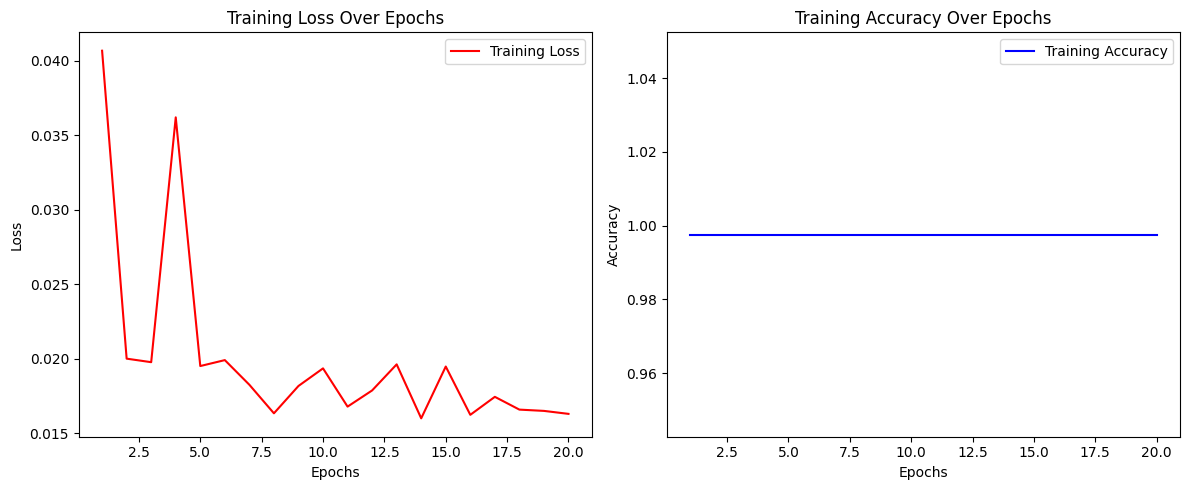

Final Training Accuracy: 99.76%


In [74]:
plot_training_history(hattnet)
print_final_accuracy(hattnet)

## 8. Saving the models

In [82]:
hunet.model.save('/kaggle/working/hunet_model.h5')

In [83]:
hdl.model.save('/kaggle/working/hdl_model.h5')

In [84]:
henet.model.save('/kaggle/working/henet_model.h5')

In [85]:
hattnet.model.save('/kaggle/working/hattnet_model.h5')